# Caso 2 - Avión - Lineal 4 variables estado

Las ecuaciones diferenciales del modelo, solo para pequeños angulos son:

$\dot{\alpha} =a(\phi -\alpha )$

$\ddot{\phi }=-\omega ^{2}(\phi -\alpha -b\cdot u)$

$\dot{h}=c \alpha $



## Representacion espacio de estados

In [37]:
# Importacion de librerias

import numpy as np
import control as ct
import math
import pandas as pd
import matplotlib.pyplot as plt
from control.matlab import *
import cmath as cm
from math import log
import sympy as sp
from scipy import signal

In [52]:
# x1=alpha x2=phi x3=phi_p x4=h

# Definir los parámetros del sistema
a = 0.07
omega = 9
b = 5
c = 150


# Definir las matrices A, B, C, D del sistema
A = np.array([[-a, a, 0, 0],
              [0, 0, 1, 0],
              [omega**2, -omega**2, 0, 0],
              [c, 0, 0, 0]])

B = np.array([[0], [0], [b * omega**2], [0]])

C = np.array([[0, 0, 0, 1], #
              [0, 1, 0, 0]]) #

#C = np.array([[0, 0, 0, 1]])

D = np.array([[0],[0]])


Los polos a ubicar son $u_i=-15\pm 15j $ ; $-0.5\pm 0.5j$ son 4polos, 2 pares complejos conjugados.


In [53]:
p1=-15+15j
p2 = -15 - 15j
p3 = -0.5 + 0.5j
p4 = -0.5 - 0.5j

poles = np.array([p1, p2, p3, p4])

K=K = ct.acker(A, B, poles)
print("Ganancia K:", K)

# Calcular la matriz Ap del sistema de lazo cerrado
Ap = A - B @ K
print("Matriz Ap del sistema de lazo cerrado:", Ap)
# Crear el sistema de lazo cerrado
sysCL = ct.ss(Ap, B, C, D)
print("Sistema de lazo cerrado:", sysCL)

# Obtener los polos del sistema de lazo cerrado
closed_loop_poles = ct.poles(sysCL)
print("Polos del sistema de lazo cerrado:", closed_loop_poles)

#Calcular la ganancia de prealimentación G
C_out = np.array([[0, 0, 0, 1]])
G = np.linalg.inv(C_out @ np.linalg.inv(Ap) @ B)

print("Ganancia G:", G)
print("Dimensiones de G:", G.shape)  # Confirmar que G es un escalar



Ganancia K: [[15.42104257  0.98107383  0.07637037  0.05291005]]
Matriz Ap del sistema de lazo cerrado: [[-7.00000000e-02  7.00000000e-02  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [-6.16452224e+03 -4.78334900e+02 -3.09300000e+01 -2.14285714e+01]
 [ 1.50000000e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Sistema de lazo cerrado: <StateSpace>: sys[8]
Inputs (1): ['u[0]']
Outputs (2): ['y[0]', 'y[1]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[-7.00000000e-02  7.00000000e-02  0.00000000e+00  0.00000000e+00]
     [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
     [-6.16452224e+03 -4.78334900e+02 -3.09300000e+01 -2.14285714e+01]
     [ 1.50000000e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

B = [[  0.]
     [  0.]
     [405.]
     [  0.]]

C = [[0. 0. 0. 1.]
     [0. 1. 0. 0.]]

D = [[0.]
     [0.]]

Polos del sistema de lazo cerrado: [-15. +15.j  -15. -15.j   -0.5 +0.5j  -0.5 -0.5j]
Ga

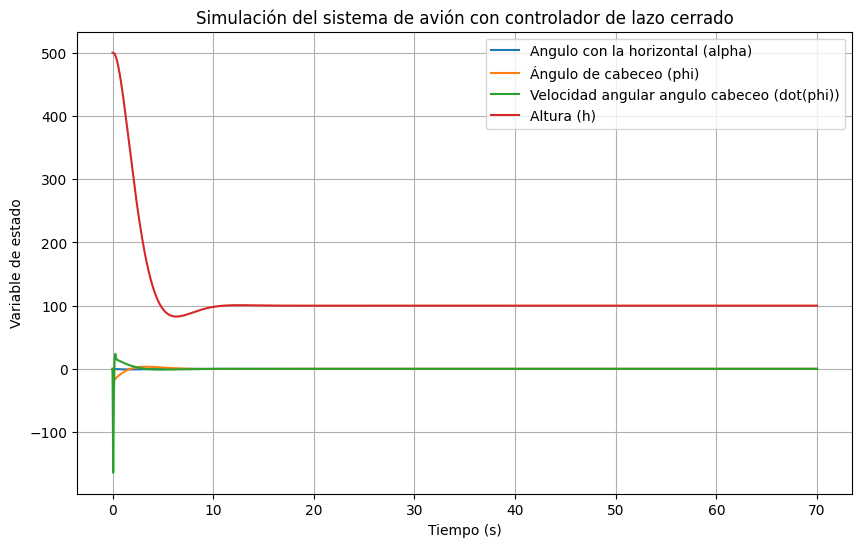

In [57]:
from scipy.integrate import odeint
# Definir la referencia
reference = -100 
# Definir la función del sistema de espacio de estados
def system(x, t):

    G=-0.05291005
    r = reference
    #u = -K @ x
    u = -K @ x+G*r
    dxdt = A @ x + B @ u
    return dxdt

# Condiciones iniciales y tiempo de simulación
x0 = np.array([0, 0, 0,500])  # Condiciones iniciales de altura y velocidades
t = np.linspace(0, 70, 1000)  # Tiempo de simulación

# Integrar el sistema de ecuaciones diferenciales utilizando odeint
x = odeint(system, x0, t)

# Gráficos de las variables de estado
plt.figure(figsize=(10, 6))
plt.plot(t, x[:, 0], label='Angulo con la horizontal (alpha)')
plt.plot(t, x[:, 1], label='Ángulo de cabeceo (phi)')
plt.plot(t, x[:, 2], label='Velocidad angular angulo cabeceo (dot(phi))')
plt.plot(t, x[:, 3], label='Altura (h)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Variable de estado')
plt.title('Simulación del sistema de avión con controlador de lazo cerrado')
plt.legend()
plt.grid(True)
plt.show()


## Observador

In [41]:
# Transponer las matrices 
#Ao = np.transpose(A)
#Bo = np.transpose(C)
#Co = np.transpose(B)

#Qo=np.diag([100,10000,100,10000])
#Ro = np.diag([1000000,1000000])
#Ko=ct.lqr(Ao,Bo,Qo,Ro)

ko= [[ 0.0100094127,  0.00355753069, -0.0116816835,  1.73574513],
       [ 0.000120287644, 0.0524230437,  -0.00361958423, 0.00355753069]]

Ko=np.transpose(ko)
#NUEVAMENTE SLYCOT NO FUNCIONA, RESUELVO ESTO EN COLLAB Y OBTENGO Ko

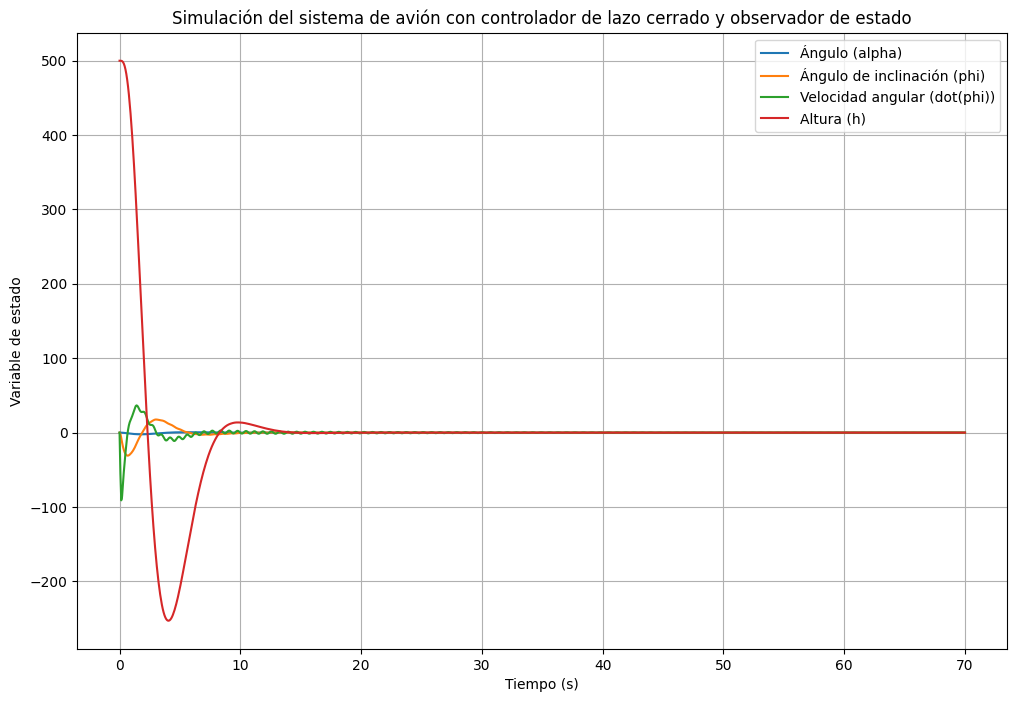

In [64]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#G=-0.05291005

# Definir la referencia
# Definir la función de referencia
#reference = lambda t: -100


# Definir la función del sistema de espacio de estados con observador
def system_with_observer(x, t):
    x_hat = x[4:]  # Estimaciones del estado (observador)
    x_real = x[:4]  # Estados reales del sistema
    r = reference
    
    u = -K @ x_hat  # Controlador basado en las estimaciones
    
    dx_real = A @ x_real + B @ u  # Dinámica del sistema real
    y = C @ x_real  # Salidas medidas del sistema real
    
    dx_hat = (A - Ko @ C) @ x_hat+ B @ u + Ko @ y  # Dinámica del observador
    #dx_hat = (A - Ko @ C) @ x_hat + B @ u + Ko @ y + G * (r - C @ x_hat)
    dxdt = np.hstack((dx_real, dx_hat))  # Combinar dinámicas para odeint
    return dxdt 

# Condiciones iniciales y tiempo de simulación
x0_real = np.array([0, 0, 0, 500])  # Condiciones iniciales reales
x0_hat = np.array([0, 0, 0, 0])  # Estimaciones iniciales (observador)
x0 = np.hstack((x0_real, x0_hat))  # Condiciones iniciales combinadas
t = np.linspace(0, 70, 1000)  # Tiempo de simulación

# Integrar el sistema de ecuaciones diferenciales utilizando odeint
x = odeint(system_with_observer, x0, t)

# Gráficos de las variables de estado
plt.figure(figsize=(12, 8))
plt.plot(t, x[:, 0], label='Ángulo (alpha)')
plt.plot(t, x[:, 1], label='Ángulo de inclinación (phi)')
plt.plot(t, x[:, 2], label='Velocidad angular (dot(phi))')
plt.plot(t, x[:, 3], label='Altura (h)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Variable de estado')
plt.title('Simulación del sistema de avión con controlador de lazo cerrado y observador de estado')
plt.legend()
plt.grid(True)
plt.show()


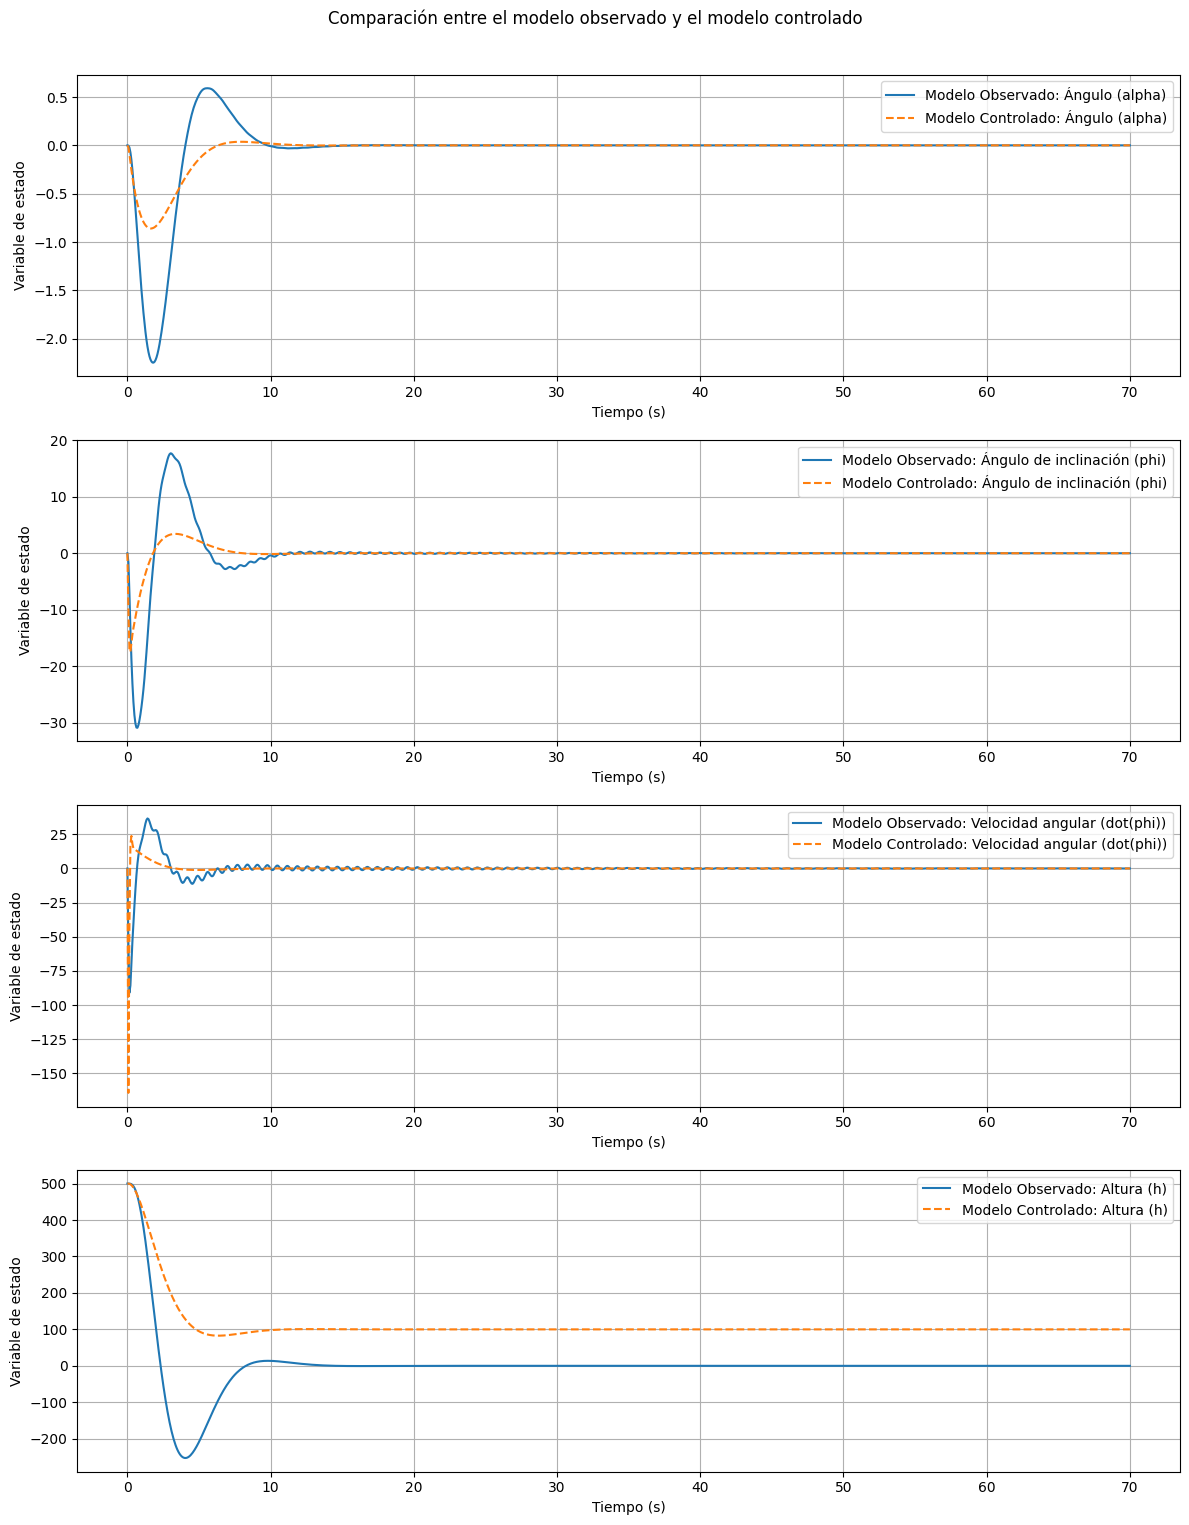

In [59]:
# Condiciones iniciales y tiempo de simulación
x0_real = np.array([0, 0, 0, 500])  # Condiciones iniciales reales
x0_hat = np.array([0, 0, 0, 0])  # Estimaciones iniciales (observador)
x0_combined = np.hstack((x0_real, x0_hat))  # Condiciones iniciales combinadas
t = np.linspace(0, 70, 1000)  # Tiempo de simulación

# Integrar el sistema de ecuaciones diferenciales utilizando odeint
x_combined = odeint(system_with_observer, x0_combined, t)
x_controlled = odeint(system, x0_real, t)

# Graficar las variables de estado y compararlas
fig, axs = plt.subplots(4, 1, figsize=(12, 16))

variables = ['Ángulo (alpha)', 'Ángulo de inclinación (phi)', 'Velocidad angular (dot(phi))', 'Altura (h)']

for i in range(4):
    axs[i].plot(t, x_combined[:, i], label=f'Modelo Observado: {variables[i]}')
    axs[i].plot(t, x_controlled[:, i], label=f'Modelo Controlado: {variables[i]}', linestyle='--')
    axs[i].set_xlabel('Tiempo (s)')
    axs[i].set_ylabel('Variable de estado')
    axs[i].legend()
    axs[i].grid(True)

plt.suptitle('Comparación entre el modelo observado y el modelo controlado')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

## Acción de control Ut

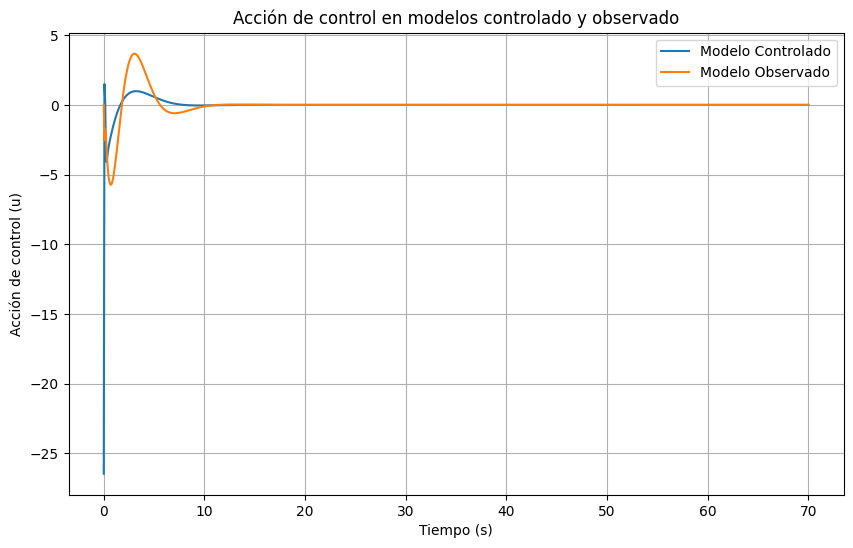

In [44]:
# Definir la función para calcular la acción de control
def control_action(x, t):
    r = reference(t)
    u = -K @ x 
    return u

# Definir la función para calcular la acción de control con observador
def control_action_with_observer(x, t):
    x_hat = x[4:]  # Estimaciones del estado (observador)
    r = reference(t)
    u = -K @ x_hat # Controlador basado en las estimaciones
    return u


# Calcular la acción de control para ambos modelos
u_controlled = np.array([control_action(xi, ti) for xi, ti in zip(x_controlled, t)]).flatten()
u_observer = np.array([control_action_with_observer(xi, ti) for xi, ti in zip(x_combined, t)]).flatten()

# Graficar la acción de control para ambos modelos superpuestos
plt.figure(figsize=(10, 6))
plt.plot(t, u_controlled, label='Modelo Controlado')
plt.plot(t, u_observer, label='Modelo Observado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Acción de control (u)')
plt.title('Acción de control en modelos controlado y observado')
plt.legend()
plt.grid(True)
plt.show()

## Controlador tiempo discreto

In [45]:
# Partiendo de las matrices del modelo 

# Definir los parámetros del sistema
a = 0.07
omega = 9
b = 5
c = 150


# Definir las matrices A, B, C, D del sistema
A = np.array([[-a, a, 0, 0],
              [0, 0, 1, 0],
              [omega**2, -omega**2, 0, 0],
              [c, 0, 0, 0]])

B = np.array([[0], [0], [b * omega**2], [0]])

C = np.array([[0, 0, 0, 1], #
              [0, 1, 0, 0]]) #

D = np.array([[0],[0]])


### Tiempo de muestreo

In [46]:
# Calcular los polos del sistema
poles = np.linalg.eigvals(A)
print('Polos:', poles)

# Seleccionar el polo dominante (uno de los polos complejos conjugados)
dominant_complex_pole = poles[1]

# Calcular el tiempo de muestreo utilizando el método de los polos dominantes
sampling_time = np.log(0.95) / np.abs(dominant_complex_pole.real)

print('Tiempo de muestreo óptimo:', sampling_time)

Polos: [ 0.00000000e+00+0.j         -3.50000000e-02+8.99993194j
 -3.50000000e-02-8.99993194j -1.39257604e-17+0.j        ]
Tiempo de muestreo óptimo: -1.4655226967871593


In [47]:
from scipy.signal import cont2discrete

Ts=0.001

# Discretize the system using the ZOH method
Ad, Bd, Cd, Dd, _ = cont2discrete((A, B, C, D), Ts, method='zoh')

# Create the discrete system
sysd = ss(Ad, Bd, Cd, Dd, Ts)
print('Discrete system:')
print(sysd)

#Polos deseados para el controlador continuo
#p1 = -15 + 15j
#p2 = -15 - 15j
#p3 = -0.5 + 0.5j
#p4 = -0.5 - 0.5j

# Polos deseados para el controlador continuo
p_cont = np.array([-15 + 15j, -15 - 15j, -0.5 + 0.5j, -0.5 - 0.5j])

# Discretizar los polos deseados
p_disc = np.exp(p_cont * Ts)

print('Polos discretos:', p_disc)

# Calcular la ganancia del controlador en tiempo discreto usando Ackermann
def acker(A, B, poles):
    n = A.shape[0]
    char_poly = np.poly(poles)
    A_poly = np.poly(A)
    K = np.zeros((1, n))
    for i in range(n):
        K += char_poly[i + 1] * np.linalg.matrix_power(A, n - i - 1)
    K = np.real(K @ np.linalg.inv(np.vander(np.linalg.eigvals(A), increasing=True)).T @ np.linalg.inv(B))
    return K

#K_discrete = acker(Ad, Bd, p_disc)

Discrete system:
<StateSpace>: sys[7]
Inputs (1): ['u[0]']
Outputs (2): ['y[0]', 'y[1]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[ 9.99930003e-01  6.99966051e-05  3.49989471e-08  0.00000000e+00]
     [ 4.04987816e-05  9.99959501e-01  9.99986500e-04  0.00000000e+00]
     [ 8.09960716e-02 -8.09960716e-02  9.99959501e-01  0.00000000e+00]
     [ 1.49994750e-01  5.24984207e-06  1.74996229e-09  1.00000000e+00]]

B = [[4.72489818e-09]
     [2.02498633e-04]
     [4.04994533e-01]
     [1.77184541e-10]]

C = [[0. 0. 0. 1.]
     [0. 1. 0. 0.]]

D = [[0.]
     [0.]]

dt = 0.001

Polos discretos: [0.98500112+0.01477612j 0.98500112-0.01477612j 0.9995    +0.00049975j
 0.9995    -0.00049975j]


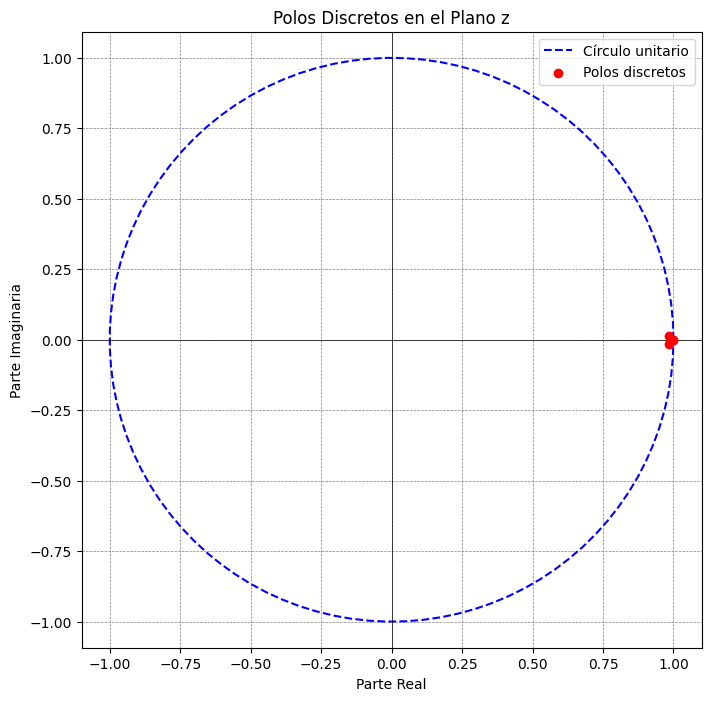

In [48]:
p_disc

# Círculo unitario
unit_circle = np.exp(1j * np.linspace(0, 2 * np.pi, 100))

# Crear la figura y el eje
plt.figure(figsize=(8, 8))
plt.plot(unit_circle.real, unit_circle.imag, 'b--', label='Círculo unitario')
plt.scatter(p_disc.real, p_disc.imag, color='red', label='Polos discretos', zorder=5)

# Configurar los ejes y el título
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('Polos Discretos en el Plano z')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.legend()
plt.axis('equal')
plt.show()


In [49]:
# Calcular la ganancia del controlador usando el método de Ackermann
K_discrete = ct.acker(Ad, Bd, p_disc)
print('Ganancia del controlador en tiempo discreto:', K_discrete)


Ganancia del controlador en tiempo discreto: [[15.19095444  0.96349115  0.07568397  0.05209841]]


/tmp/ipykernel_25434/425642664.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[k] = -K @ x[k]


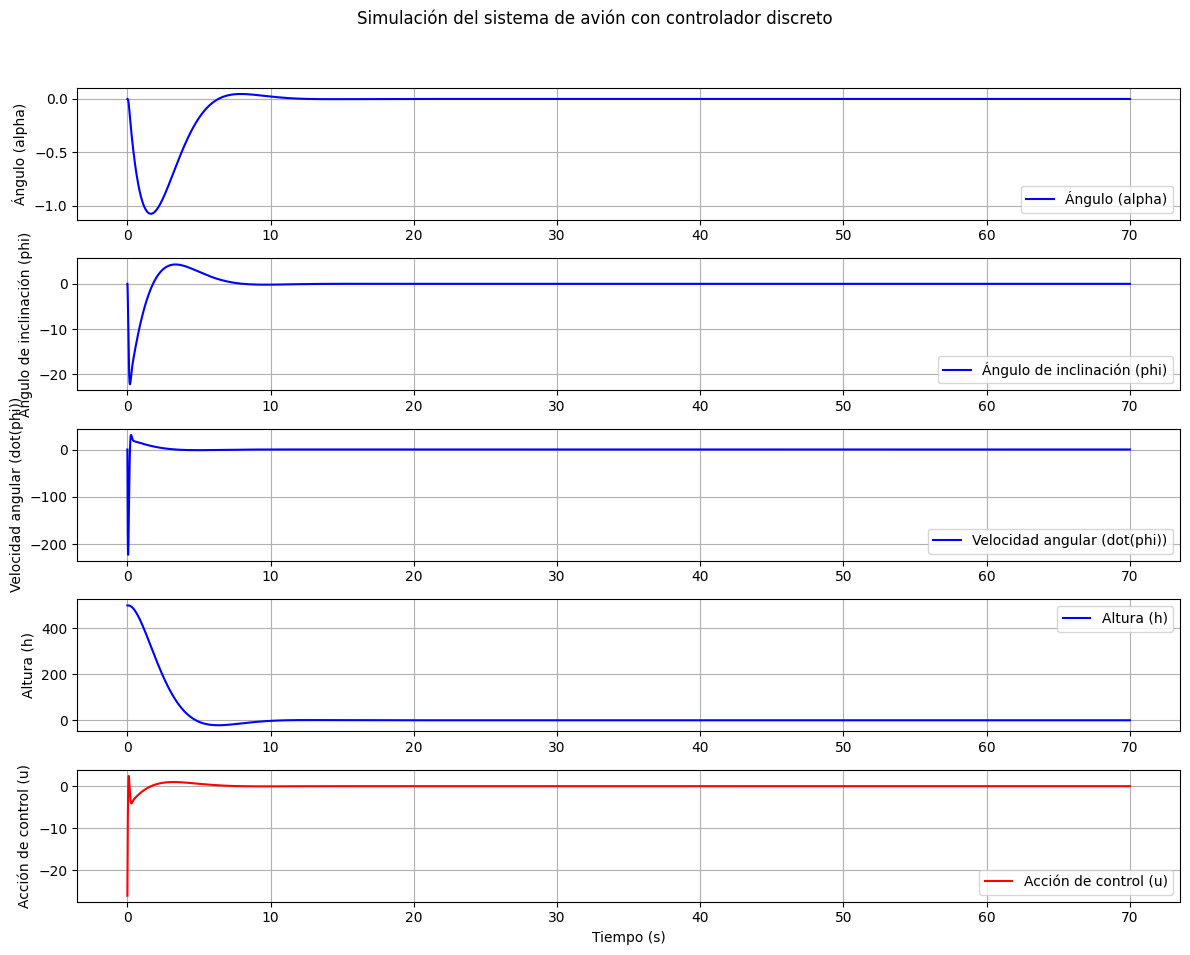

In [50]:
# Definir la referencia
def reference(t):
    if t < 35:
        return 100
    else:
        return -100

# Simular el sistema con el controlador discreto
def simulate_discrete_system(Ad, Bd, Cd, K, x0, t):
    x = np.zeros((len(t), len(x0)))
    x[0] = x0
    u = np.zeros(len(t))
    for k in range(len(t) - 1):
        r = reference(t[k])
        u[k] = -K @ x[k]
        x[k + 1] = Ad @ x[k] + Bd.flatten() * u[k]
    return x, u

# Condiciones iniciales y tiempo de simulación
x0_real = np.array([0, 0, 0, 500])
t = np.arange(0, 70, Ts)  # Tiempo de simulación

# Simular el sistema controlado
x_controlled, u_controlled = simulate_discrete_system(Ad, Bd, Cd, K_discrete, x0_real, t)

# Graficar las variables de estado
plt.figure(figsize=(12, 10))

variables = ['Ángulo (alpha)', 'Ángulo de inclinación (phi)', 'Velocidad angular (dot(phi))', 'Altura (h)']
for i in range(4):
    plt.subplot(5, 1, i+1)
    plt.plot(t, x_controlled[:, i], label=variables[i], color='b')
    plt.ylabel(variables[i])
    plt.grid(True)
    plt.legend()

# Graficar la acción de control
plt.subplot(5, 1, 5)
plt.plot(t, u_controlled, label='Acción de control (u)', color='r')
plt.xlabel('Tiempo (s)')
plt.ylabel('Acción de control (u)')
plt.grid(True)
plt.legend()

plt.suptitle('Simulación del sistema de avión con controlador discreto')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [66]:
## Planteo observador

#Aod=np.transpose(Ad)
#Bod=np.transpose(Cd)

# Definir matrices de peso para el diseño del observador
#Qod = np.diag([100, 10000, 100, 10000])
#Rod = np.diag([1000000, 1000000])

# Calcular la ganancia LQR
#K, _, _ = ct.dlqr(Aod, Bod, Qod, Rod)

#print("Ganancia del controlador LQR:")
#print(K)

#Kod=np.transpose(K)
#print(Kod)

K = [[0.0093907, 0.00054646, 0.0550353, 0.1090607],
    [0.00038259, 0.09529, 0.00852221, 0.00054868]]

Kod = np.transpose(K)
print(Kod)


[[0.0093907  0.00038259]
 [0.00054646 0.09529   ]
 [0.0550353  0.00852221]
 [0.1090607  0.00054868]]


In [71]:

from scipy.integrate import solve_ivp
##Simulacion

reference = -100
# Convertir el sistema a tiempo discreto
dt = 0.01  # Intervalo de muestreo
A_d, B_d, C_d, _, _ = cont2discrete((A, B, C, None), dt)

# Definir la función del sistema de espacio de estados con observador en tiempo discreto
def system_with_observer_discrete(t, x, A_d, B_d, C_d, Kod):
    x_hat = x[4:]  # Estimaciones del estado (observador)
    x_real = x[:4]  # Estados reales del sistema
    r = reference
    
    u = -Kod @ x_hat  # Controlador basado en las estimaciones
    
    dx_real = A_d @ x_real + B_d * u  # Dinámica del sistema real
    y = C_d @ x_real  # Salidas medidas del sistema real
    
    dx_hat = (A_d - Kod @ C_d) @ x_hat + B_d * u + Kod @ y  # Dinámica del observador
    
    return np.hstack((dx_real, dx_hat)) 

# Condiciones iniciales y tiempo de simulación
x0_real = np.array([0, 0, 0, 500])  # Condiciones iniciales reales
x0_hat = np.array([0, 0, 0, 0])  # Estimaciones iniciales (observador)
x0 = np.hstack((x0_real, x0_hat))  # Condiciones iniciales combinadas
t = np.linspace(0, 70, int(70/dt)+1)  # Tiempo de simulación

# Integrar el sistema de ecuaciones diferenciales utilizando solve_ivp
sol = solve_ivp(system_with_observer_discrete, [t[0], t[-1]], x0, args=(A_d, B_d, C_d, Kod), t_eval=t)
x = sol.y.T

# Gráficos de las variables de estado
plt.figure(figsize=(12, 8))
plt.plot(t, x[:, 0], label='Ángulo (alpha)')
plt.plot(t, x[:, 1], label='Ángulo de inclinación (phi)')
plt.plot(t, x[:, 2], label='Velocidad angular (dot(phi))')
plt.plot(t, x[:, 3], label='Altura (h)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Variable de estado')
plt.title('Simulación del sistema de avión con controlador de lazo cerrado y observador de estado (Tiempo discreto)')
plt.legend()
plt.grid(True)
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 2)